In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
from collections import defaultdict
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
print(np.__version__)
print(pd.__version__)

1.22.3
1.4.2


In [3]:
from pymatgen.core import Composition
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDEntry

In [4]:
os.chdir('../')

In [5]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
from rlmolecule.crystal.crystal_state import CrystalState
from rlmolecule.crystal.crystal_reward import StructureRewardBattInterface
from rlmolecule.crystal import ehull
from rlmolecule.crystal.ehull import fere_entries

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


2022-07-12 13:21:32.335028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nopt/slurm/current/lib:
2022-07-12 13:21:32.335061: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
INFO:rdkit:Enabling RDKit 2022.03.2 jupyter extensions


## Compute the self-consistent decomposition energy for all 14.3M decorations
1. Get the lowest predicted energy for all 200K compositions
2. Use those + ICSD to build the updated competing phases 
3. Recompute the reward for all decorations

In [7]:
all_decors_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/all_decor_rewards.csv.gz"
data = pd.read_csv(all_decors_file)
print(len(data))
data.head(2)

14277451


,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
0,Li1Ti2Ge1Cl1N4_icsd_419182_4,Li1Ti2Ge1Cl1N4,0.015,0.299,7.325,0.111,NaN,NaN,NaN
1,Li1La1Sb1I3O3_icsd_171662_12,Li1La1Sb1I3O3,0.036,-0.391,4.621,0.111,NaN,NaN,NaN


In [8]:
# get the structure with the lowest predicted total energy per composition
data_comp = data.sort_values('predicted_energy').groupby('comp').agg({'id': 'first'})

In [9]:
data_best = data[data.id.isin(data_comp.id)]
print(len(data_best))
data_best.head(2)

220824


,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
74,Li2W1Zn1Br2I8_icsd_408052_1,Li2W1Zn1Br2I8,0.257,-2.055,0.726,0.143,NaN,NaN,NaN
146,Li4Cd1Al2O4S2_icsd_413705_4,Li4Cd1Al2O4S2,0.209,-2.595,2.782,0.308,NaN,NaN,NaN


<AxesSubplot:>

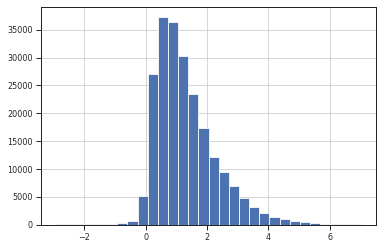

In [10]:
data_best.decomp_energy.hist(bins=30)

In [11]:
def setup_competing_phases(competing_phases_files):
    if not isinstance(competing_phases_files, list):
        competing_phases_files = [competing_phases_files]
    all_competing_phases = [load_competing_phases(f) for f in competing_phases_files]

    # also add the individual elements
    competing_phases = pd.concat([pd.Series(fere_entries)] + all_competing_phases).reset_index()[0]
    return competing_phases


def load_competing_phases(competing_phases_file):
    print(f"Reading {competing_phases_file}")
    df = pd.read_csv(competing_phases_file)
    print(f"\t{len(df)} lines")
    print(df.head(2))

    assert ('sortedformula' in df.columns or 'comp' in df.columns) \
        and ('energyperatom' in df.columns or 'predicted_energy' in df.columns)
    if 'sortedformula' not in df.columns:
        df.rename(columns={'comp': 'sortedformula'}, inplace=True)
    if 'energyperatom' not in df.columns:
        df.rename(columns={'predicted_energy': 'energyperatom'}, inplace=True)
    print("columns after renaming:", df.columns)

    df['energy'] = (
        df.energyperatom *
        df.sortedformula.apply(lambda x: Composition(x).num_atoms)
    )
    # convert the dataframe to a list of PDEntries used to create the convex hull
    pd_entries = df.apply(
        lambda row: PDEntry(Composition(row.sortedformula),
                            row.energy),
        axis=1
    )
    print(f"\t{len(pd_entries)} entries")
    return pd_entries

In [12]:
competing_phases_file = "/projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv"
competing_phases = setup_competing_phases(competing_phases_file)

Reading /projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4
columns after renaming: Index(['sortedformula', 'icsdnum', 'energyperatom', 'reduced_composition'], dtype='object')
	12682 entries


In [13]:
# now include the predicted energies in the convex hull 
def make_pd_entry(row):
    comp = Composition(row.comp)
    energy = row.predicted_energy * comp.num_atoms
    return PDEntry(comp, energy)

pred_competing_phases = list(data_best.apply(make_pd_entry, axis=1))
print(pred_competing_phases[:2])
merged_competing_phases = list(competing_phases) + pred_competing_phases
print(len(merged_competing_phases))

[PDEntry : Li2 W1 Zn1 Br2 I8 with energy = -28.7700, PDEntry : Li4 Cd1 Al2 O4 S2 with energy = -33.7350]
233564


In [14]:
# compute the self-consistent decomposition energy
def compute_reward(row):
    combined_reward, info = rewarder.compute_reward(
        Composition(row.comp), row.predicted_energy)
    info['reward'] = combined_reward
    return info
                            

rewarder = StructureRewardBattInterface(merged_competing_phases)

new_data = data.progress_apply(compute_reward, axis=1)
list(new_data.items())[:2]

  0%|          | 0/14277451 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Computing for all decorations is taking too long. Instead, recompute for only the best candidates 

In [19]:
rewards_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/self_consistent_decomp_energies.csv"
df_best = pd.read_csv(rewards_file)
print(len(df))
df_best.head(2)

2003


,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
0,K3Y1Al1Br9|_1_1_3_9|hexagonal|icsd_039809|2,0.298,-3.460,0.171,0.214,NaN,NaN,NaN
1,Li1Sc3F8Br2|_1_2_3_8|tetragonal|icsd_067711|1,0.344,-5.484,-0.015,0.071,-5.0,-5.0,0.0


In [21]:
# compute the self-consistent decomposition energy
def compute_reward(row):
    comp = row.decor_id.split('|')[0]
    combined_reward, info = rewarder.compute_reward(
        Composition(comp), row.predicted_energy)
    info['reward'] = combined_reward
    return info
                            

rewarder = StructureRewardBattInterface(merged_competing_phases)

new_data = df_best.progress_apply(compute_reward, axis=1)
list(new_data.items())[:2]

  0%|          | 0/2003 [00:00<?, ?it/s]

[(0,
  {'predicted_energy': -3.46,
   'decomp_energy': 0.1707,
   'cond_ion_frac': 0.2143,
   'reward': 0.29805456812419584}),
 (1,
  {'predicted_energy': -5.484,
   'oxidation': -5,
   'reduction': -5,
   'stability_window': 0,
   'decomp_energy': -0.0153,
   'cond_ion_frac': 0.0714,
   'reward': 0.344104187265275})]

In [28]:
new_data

0       {'predicted_energy': -3.46, 'decomp_energy': 0...
1       {'predicted_energy': -5.484, 'oxidation': -5, ...
2       {'predicted_energy': -3.281, 'oxidation': -5, ...
3       {'predicted_energy': -3.854, 'decomp_energy': ...
4       {'predicted_energy': -3.845, 'decomp_energy': ...
                              ...                        
1998    {'predicted_energy': -3.005, 'decomp_energy': ...
1999    {'predicted_energy': -4.311, 'decomp_energy': ...
2000    {'predicted_energy': -2.961, 'decomp_energy': ...
2001    {'predicted_energy': -2.691, 'decomp_energy': ...
2002    {'predicted_energy': -3.231, 'decomp_energy': ...
Length: 2003, dtype: object

In [24]:
len([x for x in new_data if x['decomp_energy'] < -.1])

19

In [32]:
new_df = pd.DataFrame(list(new_data.values))
new_df['decor_id'] = df_best.decor_id
new_df.head(2)

,predicted_energy,decomp_energy,cond_ion_frac,reward,oxidation,reduction,stability_window,decor_id
0,-3.460,0.1707,0.2143,0.298055,NaN,NaN,NaN,K3Y1Al1Br9|_1_1_3_9|hexagonal|icsd_039809|2
1,-5.484,-0.0153,0.0714,0.344104,-5.0,-5.0,0.0,Li1Sc3F8Br2|_1_2_3_8|tetragonal|icsd_067711|1


In [34]:
out_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/all_self_cons_decomp_energies.csv"
new_df.to_csv(out_file, index=False)

In [25]:
len([x for x in new_data if x['decomp_energy'] < 0])

131

In [23]:
new_df = pd.DataFrame(new_data)
new_df.head(2)

,0
0,"{'predicted_energy': -3.46, 'decomp_energy': 0..."
1,"{'predicted_energy': -5.484, 'oxidation': -5, ..."


### Check model for structures already in ICSD

In [28]:
competing_phases[100]

PDEntry : Ag1 Bi1 K2 with energy = -8.3651

In [27]:
comp_phase_to_energy = {e.composition: e.energy for e in competing_phases}

In [20]:
# if the composition is already in ICSD, then skip it unless the energy per atom is lower
data_best['in_icsd'] = data_best.comp.apply(lambda x: Composition(x) in comp_phase_to_energy)
data_best.in_icsd.sum()

/tmp/ipykernel_14127/1225921386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_best['in_icsd'] = data_best.comp.apply(lambda x: Composition(x) in icsd_comps)


361

In [41]:
def check_if_better(row):
    comp = Composition(row.comp)
    energy = row.predicted_energy * comp.num_atoms 
    return (energy - comp_phase_to_energy[comp]) / comp.num_atoms

In [42]:
data_best.loc[data_best.in_icsd, 'vs_icsd'] = data_best[data_best.in_icsd].apply(check_if_better, axis=1)
data_best[data_best.vs_icsd < 0]

,id,comp,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window,in_icsd,vs_icsd
347986,K1F2O2P1_icsd_026640_1,K1F2O2P1,0.402000,-5.864000,-0.0150,0.1670,-2.3350,-5.0000,2.6650,True,-0.017397
792553,Na2W1F4O2_icsd_201173_1,Na2W1F4O2,0.367000,-5.956000,-0.0100,0.2220,-3.8100,-4.3680,0.5580,True,-0.010736
1542277,K2F1O3P1_icsd_172343_1,K2F1O3P1,0.428000,-5.883000,-0.0050,0.2860,-1.6460,-4.1040,2.4570,True,-0.005434
1986952,Na3W1F1O4_icsd_417289_1,Na3W1F1O4,0.435000,-6.217000,-0.0100,0.3330,-1.5750,-3.1020,1.5270,True,-0.009768
7537077,Li2O2N1P1_icsd_188494_1,Li2O2N1P1,0.442000,-6.462000,-0.0160,0.3330,-1.0150,-2.9190,1.9040,True,-0.015901
...,...,...,...,...,...,...,...,...,...,...,...
12938490,Li2Cd1Sn1S4_icsd_262388_2,Li2Cd1Sn1S4,0.372397,-4.051142,-0.0367,0.2500,-1.7071,-2.7680,1.0609,True,-0.036670
12943190,Li1Ti1O5P1_icsd_039761_1,Li1Ti1O5P1,0.368395,-7.339676,-0.0115,0.1250,-2.3865,-4.2812,1.8947,True,-0.017994
12951436,Na1Hg1O4P1_icsd_032511_1,Na1Hg1O4P1,0.362537,-5.539109,-0.0112,0.1429,-2.7818,-4.0456,1.2639,True,-0.011188
12993774,Li1Zn1S4P1_icsd_095785_1,Li1Zn1S4P1,0.334587,-4.263132,-0.0178,0.1429,-2.1514,-2.8895,0.7382,True,-0.017796


<AxesSubplot:>

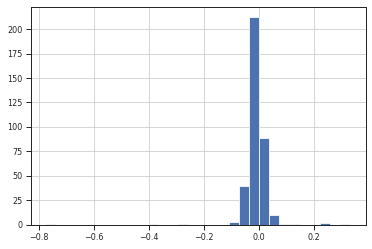

In [43]:
data_best.vs_icsd.hist(bins=30)

In [51]:
print(data_best[data_best.vs_icsd < -.05][['comp', 'predicted_energy', 'vs_icsd']].sort_values('vs_icsd').to_string(index=False))

      comp  predicted_energy   vs_icsd
   Li7I1N2         -3.697300 -0.773868
  Li1Zn1P1         -3.348244 -0.393907
  Li1Cd1P1         -3.152738 -0.292716
   K1Hg1F3         -3.465678 -0.108871
K2Ti1Ge3O9         -6.503984 -0.078466
  Li5Cl3O1         -3.988599 -0.076524
Li1W1Sb1O6         -7.008956 -0.063769
   Li1N2P1         -6.857761 -0.062683
  Li2Sn1O3         -5.729726 -0.057772
Li2B1Al1O4         -6.876345 -0.057580
 K1Sb1O8P2         -6.661652 -0.052255
 Na1Hg1Cl3         -2.520573 -0.051940
   Na1N7P4         -7.271319 -0.051865
Li1B1Ge1O4         -6.867076 -0.051821
K2Ti1Si3O9         -7.371894 -0.051553


In [40]:
comp_phase_to_energy[Composition("Li7I1N2")]

-29.234329

In [ ]:
rewards_file = "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/self_consistent_decomp_energies.csv"
df = pd.read_csv(rewards_file)
print(len(df))
df.head(2)

2003


,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
0,K3Y1Al1Br9|_1_1_3_9|hexagonal|icsd_039809|2,0.298,-3.460,0.171,0.214,NaN,NaN,NaN
1,Li1Sc3F8Br2|_1_2_3_8|tetragonal|icsd_067711|1,0.344,-5.484,-0.015,0.071,-5.0,-5.0,0.0


In [7]:
len(df[df.decomp_energy < -.1])

101

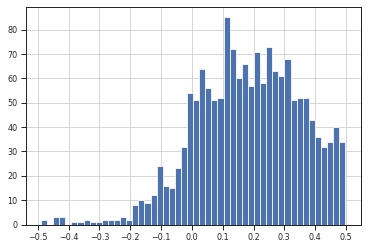

In [8]:
ax = df[(df.decomp_energy > -.5) & (df.decomp_energy < .5)].decomp_energy.hist(bins=50)
ax.set_xticks(np.arange(-.5, .6, .1))
plt.show()

<AxesSubplot:>

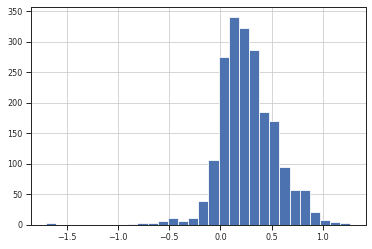

In [9]:
df.decomp_energy.hist(bins=30)

## Double check the decomposition for some structures

In [11]:
def setup_competing_phases(competing_phases_files):
    if not isinstance(competing_phases_files, list):
        competing_phases_files = [competing_phases_files]
    all_competing_phases = [load_competing_phases(f) for f in competing_phases_files]

    # also add the individual elements
    competing_phases = pd.concat([pd.Series(fere_entries)] + all_competing_phases).reset_index()[0]
    return competing_phases


def load_competing_phases(competing_phases_file):
    print(f"Reading {competing_phases_file}")
    df = pd.read_csv(competing_phases_file)
    print(f"\t{len(df)} lines")
    print(df.head(2))

    assert ('sortedformula' in df.columns or 'comp' in df.columns) \
        and ('energyperatom' in df.columns or 'predicted_energy' in df.columns)
    if 'sortedformula' not in df.columns:
        df.rename(columns={'comp': 'sortedformula'}, inplace=True)
    if 'energyperatom' not in df.columns:
        df.rename(columns={'predicted_energy': 'energyperatom'}, inplace=True)
    print("columns after renaming:", df.columns)

    df['energy'] = (
        df.energyperatom *
        df.sortedformula.apply(lambda x: Composition(x).num_atoms)
    )
    # convert the dataframe to a list of PDEntries used to create the convex hull
    pd_entries = df.apply(
        lambda row: PDEntry(Composition(row.sortedformula),
                            row.energy),
        axis=1
    )
    print(f"\t{len(pd_entries)} entries")
    return pd_entries

In [11]:
competing_phases_files = [
    "/projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv",
    "/projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/best_decor_rewards.csv.gz",
]

In [12]:
competing_phases = setup_competing_phases(competing_phases_files)

Reading /projects/rlmolecule/jlaw/rlmolecule/examples/crystal_energy/inputs/competing_phases.csv
	12682 lines
  sortedformula   icsdnum  energyperatom reduced_composition
0    Ag10Br3Te4  173116.0      -1.718985          Ag10Br3Te4
1   Ag11K1O16V4  391344.0      -4.797702         Ag11K1O16V4
columns after renaming: Index(['sortedformula', 'icsdnum', 'energyperatom', 'reduced_composition'], dtype='object')
	12682 entries
Reading /projects/rlmolecule/jlaw/crystal_outputs/2022-07-05/best_decor_rewards.csv.gz
	2003 lines
                       id      comp    reward  predicted_energy  \
0  Li3Y1Br6_icsd_053533_1  Li3Y1Br6  1.135173         -3.798492   
1  Li4Y1Br7_icsd_001322_1  Li4Y1Br7  1.132112         -3.735198   

   decomp_energy  cond_ion_frac  reduction  oxidation  stability_window  
0        -0.8512         0.3000    -0.6734       -5.0            4.3266  
1        -0.7266         0.3333    -0.6045       -5.0            4.3955  
columns after renaming: Index(['id', 'sortedformula',

In [13]:
df[df.decor_id == "Li1Ge1O1N1|_1_1_1_1|orthorhombic|icsd_183047|2"]

,decor_id,reward,predicted_energy,decomp_energy,cond_ion_frac,reduction,oxidation,stability_window
787,Li1Ge1O1N1|_1_1_1_1|orthorhombic|icsd_183047|2,0.312,-6.131,0.0,0.25,NaN,NaN,NaN


In [14]:
comp = Composition("Li1Ge1O1N1")
entry = PDEntry(comp, -24.524)
entry

PDEntry : Li1 Ge1 O1 N1 with energy = -24.5240

In [15]:
elements = set(comp.elements)
curr_entries = [e for e in competing_phases if len(set(e.composition.elements) - elements) == 0
                             and e != entry]
curr_entries

[PDEntry : Ge1 with energy = -4.3400,
 PDEntry : Li1 with energy = -1.5800,
 PDEntry : N1 with energy = -8.4600,
 PDEntry : O1 with energy = -4.8000,
 PDEntry : Ge1 Li1 with energy = -7.0905,
 PDEntry : Ge1 O2 with energy = -19.4096,
 PDEntry : Ge2 Li7 with energy = -25.4758,
 PDEntry : Ge3 N4 with energy = -47.5349,
 PDEntry : Ge4 Li15 with energy = -53.3199,
 PDEntry : Ge4 Li9 with energy = -40.0625,
 PDEntry : Ge6 Li11 with energy = -54.2760,
 PDEntry : Li1 N1 with energy = -10.8040,
 PDEntry : Li3 N1 with energy = -15.5342,
 PDEntry : Ge2 N2 O1 with energy = -33.5677,
 PDEntry : Li1 N1 O3 with energy = -29.1773,
 PDEntry : N2 O4 with energy = -35.9692,
 PDEntry : N2 O1 with energy = -16.1545,
 PDEntry : N2 O3 with energy = -30.1289,
 PDEntry : N2 O5 with energy = -40.6163,
 PDEntry : Li2 O1 with energy = -14.3010,
 PDEntry : Li4 Ge1 O4 with energy = -50.3342,
 PDEntry : Li5 Ge1 N3 with energy = -43.3063,
 PDEntry : Li2 Ge1 O3 with energy = -35.2300,
 PDEntry : Li6 Ge2 O7 with energ

In [16]:
phase_diagram = PhaseDiagram(curr_entries, elements=elements)

In [17]:
decomp, decomp_energy = phase_diagram.get_decomp_and_e_above_hull(
    entry,
    allow_negative=True,
    # docs say: "if you have a huge proportion of unstable entries,
    # then this check can slow things down."
    check_stable=False)

In [18]:
print(comp, decomp_energy)
decomp

Li1 Ge1 O1 N1 -0.0005213794708254227


{PDEntry : Li2 Ge1 O3 with energy = -35.2300: 0.5,
 PDEntry : Li1 Ge2 N3 with energy = -38.3358: 0.5}